# Logistic Regression and Naive Bayes for Sentiment Analysis

## Objective
* Perform sentiment analysis using Logistic Regression and Naive Bayes.
* Train models to classify reviews as positive (1) or negative (0).
* Use text preprocessing (e.g., tokenization, vectorization).
* Compare both models to determine which is more effective.
* Evaluate performance with accuracy, precision, recall, and F1-score.

## Dataset Description
* Source: Manually retrieved from Amazon reviews for JBL Tune 520.
* Total Samples: 116
  * Classes:
    * Positive Sentiment (1): 58 reviews (5-star ratings).
    * Negative Sentiment (0): 58 reviews (1-star ratings) & 27 reviews (2-stars ratings).


In [51]:
%matplotlib inline
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
#spacy.cli.download("en_core_web_sm")

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


## 1. Getting data ready

In [53]:
# load data
pd.set_option('future.no_silent_downcasting', True)
# read dataset
sentiment_df = pd.read_csv("./dataset/amazon_jbltune520_sample_reviews.csv")

In [88]:
#sentiment_df.groupby(by=["stars"]).count()

## 2. Preprocessing

### 2.1 Remove punctuation and filter out stop words

In [90]:
# convert text label into numerical label
sentiment_df["stars"] = sentiment_df["stars"].replace({5: 1, 1: 0, 2:0})

#trim leading/trailing spaces
sentiment_df["review"] = sentiment_df["review"].str.strip()  

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Faster loading

# Apply spaCy lemmatization
def lemmatize_spacy(text):
    doc = nlp(text.lower())  # Lowercase and process
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Remove punctuation & stopwords
    return " ".join(tokens)

# Apply to dataset
sentiment_df["lemmatized_sentence"] = sentiment_df["review"].apply(lemmatize_spacy)

#reorder target column (stars) to the last position
sentiment_df = sentiment_df[[col for col in sentiment_df.columns if col != "stars"] + ["stars"]]

sentiment_df = sentiment_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [92]:
sentiment_df.columns

Index(['review', 'lemmatized_sentence', 'stars'], dtype='object')

### 2.2. Split Date - (before vectorizer)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_df["lemmatized_sentence"], 
                                                    sentiment_df["stars"], 
                                                    test_size=0.2,
                                                    random_state=42)

### 2.3. Feature Extraction

In [100]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words="english", min_df=2, max_features=200)

X_train_vectorized = vectorizer.fit_transform(X_train)

X_test_vectorized = vectorizer.transform(X_test)

## 3. Logistic Regression: Train the Model

In [102]:
clf_log_reg = LogisticRegression(class_weight="balanced", random_state=42)

#fit the train data
clf_log_reg.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

### 3.1. Logistic Regression: Test the Model 

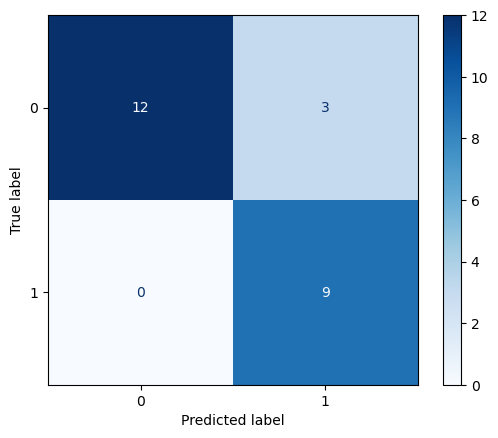

In [104]:
# predict sentiments
y_preds = clf_log_reg.predict(X_test_vectorized)

# evaluate accuracy
acc_score = accuracy_score(y_test, y_preds)
acc_score

# Confusion Matrix: how well my model is performing
cm_log_reg = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_log_reg,
                      display_labels=clf_log_reg.classes_)

disp.plot(cmap="Blues");



In [106]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.75      1.00      0.86         9

    accuracy                           0.88        24
   macro avg       0.88      0.90      0.87        24
weighted avg       0.91      0.88      0.88        24



### 4.2. Logistic Regression: Hyperparameters tunning using `GridSearchCV`

In [108]:
np.random.seed(42)
## tunning LogisticRegression clf
grid_log_reg = {"C" : np.logspace(-4, 4, 20),
               "solver" : ["liblinear", "newton-cg"],
               "class_weight": ["balanced"]}

gs_cv_log_reg = GridSearchCV(estimator = LogisticRegression(),
                             param_grid=grid_log_reg,
                             n_jobs=1,
                             scoring="accuracy",
                             cv=10,
                             verbose=0)


gs_cv_log_reg.fit(X_train_vectorized, y_train)

gs_cv_log_reg.score(X_test_vectorized, y_test)


gs_cv_log_reg.best_params_

{'C': 0.03359818286283781, 'class_weight': 'balanced', 'solver': 'liblinear'}

In [110]:
# predict
y_preds = gs_cv_log_reg.predict(X_test_vectorized)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.75      1.00      0.86         9

    accuracy                           0.88        24
   macro avg       0.88      0.90      0.87        24
weighted avg       0.91      0.88      0.88        24



## 5. Naive Bayes: Train the Model

In [112]:
np.random.seed(42)
gnb_clf = GaussianNB()

#convert sparse data into a dense array
X_train_dense = X_train_vectorized.toarray()

#fit train data
gnb_clf.fit(X_train_dense, y_train)


GaussianNB()

### 5.1 Naive Bayes: Test the Model

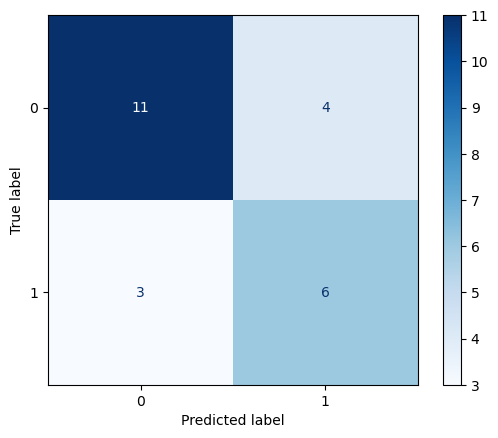

In [114]:
#convert sparse data into a dense array
X_test_dense = X_test_vectorized.toarray()

# predict sentiments
y_preds = gnb_clf.predict(X_test_dense)

# evaluate accuracy
acc_score_gnb = accuracy_score(y_test, 
                              y_preds)

# Confusion Matrix: how well my model is performing
gnb_cm = confusion_matrix(y_test,
                         y_preds,
                         labels=gnb_clf.classes_)

disp_gnb_cm = ConfusionMatrixDisplay(gnb_cm, 
                                     display_labels=gnb_clf.classes_)

disp_gnb_cm.plot(cmap="Blues");


In [116]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.60      0.67      0.63         9

    accuracy                           0.71        24
   macro avg       0.69      0.70      0.70        24
weighted avg       0.72      0.71      0.71        24



### 5.2. Naive Bayes: Hyperparameters tunning using `GridSearchCV`

In [118]:
gnb_grid = {"var_smoothing": np.logspace(-9, -6, num=10)}

gs_cv_gnb = GridSearchCV(GaussianNB(), 
                         gnb_grid, 
                         scoring="accuracy", 
                         n_jobs=1, 
                         cv=10,
                         verbose=1)

gs_cv_gnb.fit(X_train_dense, y_train)   

gs_cv_gnb.score(X_test_dense, y_test)

#gs_cv_gnb.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


0.7083333333333334

## 6. Models comparison

In [120]:
# cross validate
models = {"Logistic Regression": LogisticRegression(C= 0.004832930238571752, class_weight='balanced', solver= 'newton-cg'), 
          "Gaussian NB": GaussianNB(var_smoothing = 1e-09)}
scorings_list = ["accuracy", "precision", "recall", "f1"]
final_scores = {}

def evaluate_scorings(model, scorings, X, y):
    scores_results = {}
    for item in scorings:
        score = cross_validate(pipeline, 
                               X, 
                               y, 
                               scoring=item, 
                               cv=5)
        scores_results[item] = score["test_score"].mean()
    return scores_results

# Function to convert sparse to dense
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)


for model_name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), stop_words="english", min_df=2, max_features=200)),
        ("to_dense", to_dense),  # Converts sparse matrix to dense
        ("model", model) 
    ])
    final_scores[model_name] = evaluate_scorings(pipeline, 
                                                 scorings_list,
                                                 sentiment_df["lemmatized_sentence"],  
                                                 sentiment_df["stars"])
final_scores_df = pd.DataFrame(final_scores)

final_scores_df


,Logistic Regression,Gaussian NB
accuracy,0.827536,0.732246
precision,0.851346,0.725093
recall,0.828788,0.754545
f1,0.830303,0.731288


## 7. Plotting the comparison results

''

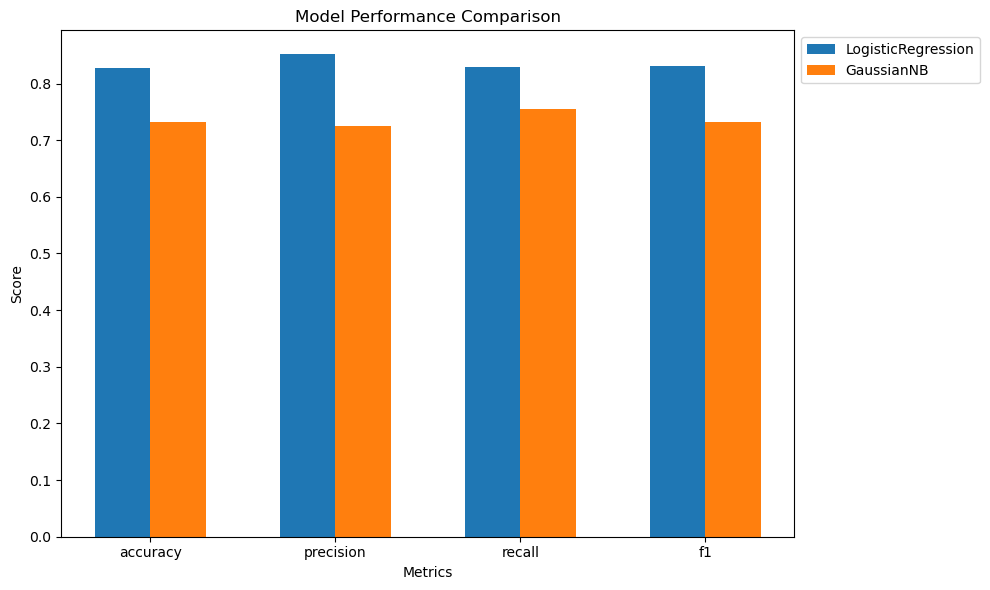

In [122]:
#set positions for the bars
x = np.arange(len(final_scores_df.index))

#width of each bar
width = 0.3

#create plot
fig, ax = plt.subplots(figsize=(10,6))

#plot the bars
##shift LogisticRegression a bit left and GaussianNB a bit right
ax.bar(x - width/2, final_scores_df["Logistic Regression"].values, width, label="LogisticRegression")
ax.bar(x + width/2, final_scores_df["Gaussian NB"].values, width, label="GaussianNB")

##format the chart
ax.set_title("Model Performance Comparison")
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(final_scores_df.index)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()


#final_scores_df["Logistic Regression"].values

;

